# Notebook

salut

In [2]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mlxtend.plotting import plot_pca_correlation_graph
import os

%matplotlib inline

In [1]:
import sys

## Data Management
### Import des données

In [3]:
cwd = os.getcwd()
os.chdir(cwd+'/Ressources')
conso = pd.read_csv('Consommation.csv',sep=';')
conso_fonction = pd.read_csv('Consommation par fonction.csv',sep=';')
os.chdir(cwd)

### Élimination des lignes et colonnes indésirables

In [4]:
conso = conso.set_index('Libellé').drop('idBank').drop('Période').drop('Codes',axis=1).astype('float64')
conso_fonction = conso_fonction.set_index('Libellé').drop('idBank').drop('Période').filter(like='Dépenses').astype('float64')

### Simplification des noms des features

In [4]:
renaming = {}
for elt in conso_fonction.columns:
    renaming[elt]=elt.lstrip('Dépense de consommation des ménages - ').rstrip('Série CVS-CJO').rstrip('Volume aux prix de l\'année précédente chaînés').rstrip(' -')

conso_fonction = conso_fonction.rename(renaming,axis='columns')

conso = conso.rename({'Dépenses de consommation des ménages - Total - Volume aux prix de l\'année précédente chaînés - Série CVS-CJO':'Total'},axis='columns')

### Séparations des comptes qui se recoupent

In [5]:
conso_fonction.columns

Index(['Produits agricoles', 'Produits agro-alimentaires',
       'Cokéfaction et raffinage', 'Biens d'équipement',
       'Matériels de transport', 'Autres produits industriels',
       'Énergie, eau, déchets', 'Construction', 'Commerce', 'Transport',
       'Hébergement-restauration', 'Information-communication',
       'Services financiers', 'Services immobiliers',
       'Services aux entreprises', 'Services non marchands (A17-OQ)',
       'Services aux ménages', 'Biens', 'Biens manufacturés',
       'Biens industriels', 'Services marchands', 'Services non marchands',
       'Services', 'Solde touristique'],
      dtype='object')

In [6]:
conso_durabilite = pd.DataFrame()
a_ecarter = ['Biens','Services','Services marchands','Biens industriels','Biens manufacturés']

for elt in a_ecarter:
    conso_durabilite[elt] = pd.Series(conso_fonction.pop(elt))

### Calcul des variation de trimestre en trimestre

Par variation nous entendons: variation = (consommation du trimestre actuel/consommation du trimestre précédent) - 1

In [7]:
variations_conso_fonction = pd.DataFrame()

for column in conso_fonction.columns:
    potiteliste = []
    for i  in range(len(conso_fonction[column])-1):
        potiteliste.append(conso_fonction[column][i+1]/conso_fonction[column][i] - 1)
    variations_conso_fonction[column] = pd.Series(potiteliste)
    
variations_conso = pd.DataFrame()
potiteliste = []
for i in range(len(conso)-1):
    potiteliste.append(conso['Total'][i+1]/conso['Total'][i] - 1)
variations_conso['Total'] = pd.Series(potiteliste)

Pour résumer le data management:
* conso contient la variable cible: la dépense de consommation finale des ménages trimestrielle
* conso_fonction contient les fonctions de consommation
* variations_conso contient les variations des dépenses de consommation finale, de trimestre en trimestre
* variations_conso_fonction fait de même pour les fonctions de consommation

## Graphiques

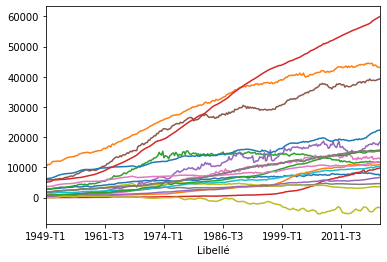

In [8]:
for column in conso_fonction.columns:
    conso_fonction[column].iloc[::-1].plot()

## ACP

In [9]:
pca = PCA()
pca.fit_transform(variations_conso_fonction)
print(np.around(pca.explained_variance_ratio_,3))

[0.97  0.011 0.005 0.005 0.002 0.002 0.001 0.001 0.001 0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.   ]


Text(0.5, 1.0, 'Variance expliquée')

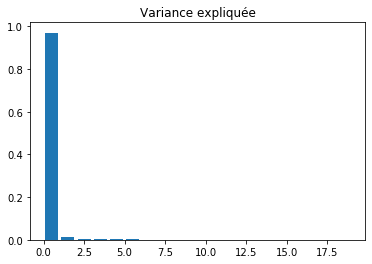

In [10]:
plt.bar(np.arange(len(pca.explained_variance_ratio_))+0.5, pca.explained_variance_ratio_)
plt.title("Variance expliquée")

L'ACP est à compléter : comment est composé ce vecteur qui explique 96% de la variance ?

## ANOVA

In [11]:
conso_tri=pd.read_csv('consotri.csv',sep=';')

In [12]:
conso_tri=conso_tri.set_index('Période').T

In [13]:
for column in conso_tri.columns:
    for i in range(0,18,1):
        conso_tri[column][i]=conso_tri[column][i].replace(',','.')
        conso_tri[column][i]=float(conso_tri[column][i])

### Calcul du poids de chaque catégorie

In [14]:
weights = pd.DataFrame()
for column in conso_tri.columns:
    cat = []
    for i in range(0,18,1):
        cat.append(conso_tri[column][i]/conso_tri[column][17])
    weights[column]= pd.Series(cat)
weights=weights.set_index(conso_tri.index)

In [15]:
t_weights=weights.iloc[:-1,:].T
mean_weights= pd.DataFrame()
for column in t_weights.columns:
    m=[t_weights[column].mean()]
    mean_weights[column]=pd.Series(m)
mean_weights.index=['Poids moyen']

In [16]:
mean_weights.T

,Poids moyen
Produits agricoles,0.029591
"Energie, eau, déchets",0.042197
Produits agro-alimentaires,0.153287
Cokéfaction et raffinage,0.042604
Biens d'équipement,0.031014
Matériels de transport,0.062478
Autres produits industriels,0.144242
Construction,0.014633
Commerce,0.012426
Transport,0.029835


### Year to year variations

Notre dernière période est le 3e trimestre de 2019, on s'arrête donc à ce trimestre. 

In [17]:
t_conso=conso_tri.T

In [18]:
yty_var = pd.DataFrame()
for column in t_conso.columns:
    var=[]
    for i in range(4,len(conso_tri.columns),1):
        var.append((t_conso[column][i]-t_conso[column][i-4])/t_conso[column][i-4])
    yty_var[column]=pd.Series(var)

In [19]:
yty_var=yty_var.set_index(t_conso.index.drop('1990T1').drop('1990T2').drop('1990T3').drop('1990T4')).T

### Variance des variations

In [20]:
t_yty = yty_var.iloc[:-1,:].T
variance= pd.DataFrame()
for column in t_yty.columns:
    v=[]
    s=0
    for i in range(0,len(t_yty[column]),1):
        s= s+ (t_yty[column][i]-t_yty[column].sum())**2
    v.append((1/(len(t_yty[column])))*s)
    variance[column]=pd.Series(v)
variance.index=['Variance de variation']

In [21]:
variance.T

,Variance de variation
Produits agricoles,6.919709
"Energie, eau, déchets",18.528795
Produits agro-alimentaires,8.391006
Cokéfaction et raffinage,9.862293
Biens d'équipement,6.055016
Matériels de transport,6.324583
Autres produits industriels,3.898548
Construction,17.123810
Commerce,9.598440
Transport,20.292428


### Part de la variance

In [22]:
share_of_variance=pd.DataFrame()
for column in variance.columns: 
    p=[]
    s=0
    for i in range(0,17,1):
        s=s+ variance.T['Variance de variation'][i]*mean_weights.T['Poids moyen'][i]
    p.append((variance[column][0]*mean_weights[column][0])/s)
    share_of_variance[column]=pd.Series(p)
share_of_variance.index=['Part de la variation']

In [23]:
share_of_variance.T

,Part de la variation
Produits agricoles,0.017251
"Energie, eau, déchets",0.065874
Produits agro-alimentaires,0.108368
Cokéfaction et raffinage,0.035401
Biens d'équipement,0.015822
Matériels de transport,0.033292
Autres produits industriels,0.047378
Construction,0.021111
Commerce,0.010049
Transport,0.051008
